In [134]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import pandas as pd
import functools 
import pickle
from copy import deepcopy
from scipy import integrate

In [135]:
# Вспомогательный класс, исполльзуемый классом Approximation.
# В физическом плане является "Элементом" метода граничных элементов.
# Интерфейс класса позволяет вычислить значения полиномов Лагранжа на узлах элемента.

class Element:
    def __init__(self, left_down_point, right_up_point, x_pol_deg, y_pol_deg):
        # left_down_point: tuple из двух элементов - координаты x и y левого нижнего края элемента
        self.left_down_point = left_down_point
        
        # right_up_point: tuple из двух элементов - координаты x и y правого верхнего края элемента
        self.right_up_point = right_up_point
        
        # x_pol_deg: int - степень многочлена Лагранжа по оси Х
        self.x_pol_deg = x_pol_deg
        
        # y_pol_deg: int - степень многочлена Лагранжа по оси Y
        self.y_pol_deg = y_pol_deg
        
        # arrx, arry: np.array - массивы координат узлов элемента
        self.arrx = np.linspace(left_down_point[0], right_up_point[0], x_pol_deg + 1, endpoint=True)
        self.arry = np.linspace(left_down_point[1], right_up_point[1], y_pol_deg + 1, endpoint=True)
        
        
    # polinom: float - функция, возвращающая значение полинома лагранжа, находящегося на позиции
    # (i_ind, j_ind) в точке x, y.
    def polinom(self, i_ind, j_ind, x, y):
        
        mx = my = 1
        for i in range(len(self.arry)):
            if (i != i_ind):
                my *= (self.arry[i_ind] - self.arry[i])
        for j in range(len(self.arrx)):
            if (j != j_ind):
                mx *= (self.arrx[j_ind] - self.arrx[j])

        m = mx * my
        res = 0
        if self.der == -1:
            res = (np.multiply.reduce(x * np.ones(self.x_pol_deg) - np.delete(self.arrx, j_ind)) * 
                   np.multiply.reduce(y * np.ones(self.y_pol_deg) - np.delete(self.arry, i_ind)))
        elif self.der == 0:
            for i in range(self.x_pol_deg + 1):
                if i == j_ind:
                    continue
                res += (np.multiply.reduce(x * np.ones(self.x_pol_deg - 1) - np.delete(self.arrx, np.array([j_ind, i])))* 
                       np.multiply.reduce(y * np.ones(self.y_pol_deg) - np.delete(self.arry, i_ind)))
        elif self.der == 1:
            for i in range(self.y_pol_deg + 1):
                if i == i_ind:
                    continue
                res += (np.multiply.reduce(x * np.ones(self.x_pol_deg) - np.delete(self.arrx, j_ind)) * 
                       np.multiply.reduce(y * np.ones(self.y_pol_deg - 1) - np.delete(self.arry, np.array([i_ind, i]))))
                
        return res / m
    
    
    # polinomials_at_point: list - матрица из соответствующих значений полиномов
    # Лагранжа в узлах в точке(x, y).
    def polinomials_at_point(self, x, y, der=-1):
        self.der = der
        res = []
        for i in range(len(self.arry)):
            for j in range(len(self.arrx)):
                res.append(self.polinom(i, j, x, y))
        return res

In [136]:
# Approximation. Класс, аппроксимирующий функцию по заданному списку точек.

class Approximation:
    
    def __init__(self, left_down_point=(-1, -1), right_up_point=(1, 1),
                 x_el_num=10, y_el_num=10, x_pol_deg=2, y_pol_deg=2, der=-1,
                 solve_function=(lambda A, B: np.linalg.lstsq(A, B, rcond=None)[0])):
        """
        left_down_point: touple. Координаты левого нижнего края прямоугольной области.  
        right_up_point: touple. Координаты правого верхнего края прямоугольной области.
        x_el_num: int. Количество элементов метода граничных элементов по оси Х.
        y_el_num: int.  Количество элементов метода граничных элементов по оси Y.
        x_pol_deg: int. Степень аппроксимирующего многочлена по оси Х.
        y_pol_deg: int. Степень аппроксимирующего многочлена по оси Х.
        der: int. "-1" - оригинал функции, "0" - производная по первому аргументу 
        оригинальной функции, "1" - по второму аргументу.
        """
        
        assert (left_down_point[0] < right_up_point[0] and left_down_point[1] < right_up_point[1]), "Bad area\n"
        self.points = []
        self.left_down_point = left_down_point
        self.right_up_point = right_up_point
        self.x_el_num = x_el_num
        self.y_el_num = y_el_num
        self.x_pol_deg = x_pol_deg
        self.y_pol_deg = y_pol_deg
        self.der = der
        self.solve_function = solve_function
        
        self.x_el_len = (right_up_point[0] - left_down_point[0]) / x_el_num
        self.y_el_len = (right_up_point[1] - left_down_point[1]) / y_el_num
        self.x_pol_num = x_el_num * x_pol_deg + 1
        self.y_pol_num = y_el_num * y_pol_deg + 1
        self.pol_num = self.x_pol_num * self.y_pol_num
        self.el_matr = [[Element((self.left_down_point[0] + self.x_el_len * j,
                                  self.left_down_point[1] + self.y_el_len * i),
                                 (self.left_down_point[0] + self.x_el_len * (j + 1),
                                  self.left_down_point[1] + self.y_el_len * (i + 1)),
                                  self.x_pol_deg,
                                  self.y_pol_deg) 
                         for j in range(self.x_el_num)]
                       for i in range(self.y_el_num)]
        
    # Метод, регулирующий матрицу в случае вырожденности.
    def matrix_fix(self):
        self.A[self.zero_checker, self.zero_checker] = 100
        self.B[self.zero_checker] = 0
        
    # Аппроксимация по заданным точкам.
    def fit(self, points):
        
        self.points += points
        
        self.A = np.zeros(shape=(self.pol_num, self.pol_num))
        self.B = np.zeros(shape=(self.pol_num, 1))
        self.zero_checker = np.full(self.pol_num, True, dtype=bool)
        
        for point in self.points:
            el_j_ind = int(min((point[0] - self.left_down_point[0]) // self.x_el_len, self.x_el_num - 1))
            el_i_ind = int(min((point[1] - self.left_down_point[1]) // self.y_el_len, self.y_el_num - 1))
            
            res = self.el_matr[el_i_ind][el_j_ind].polinomials_at_point(point[0], point[1])
            for k1 in range(self.y_pol_deg + 1):
                for m1 in range(self.x_pol_deg + 1):
                    for k2 in range(self.y_pol_deg + 1):
                        for m2 in range(self.x_pol_deg + 1):
                            self.A[el_i_ind*self.x_pol_num*self.y_pol_deg + k1*self.x_pol_num +
                                   el_j_ind*self.x_pol_deg + m1,
                                   el_i_ind*self.x_pol_num*self.y_pol_deg + k2*self.x_pol_num +
                                   el_j_ind*self.x_pol_deg + m2] += \
                                   res[k1*(self.x_pol_deg + 1) + m1] * res[k2*(self.x_pol_deg + 1) + m2]
                    self.B[el_i_ind*self.x_pol_num*self.y_pol_deg + k1*self.x_pol_num +
                           el_j_ind*self.x_pol_deg + m1] += point[2] * res[k1*(self.x_pol_deg + 1) + m1]
                    self.zero_checker[el_i_ind*self.x_pol_num*self.y_pol_deg + k1*self.x_pol_num +
                           el_j_ind*self.x_pol_deg + m1] = False
        self.matrix_fix()
#         self.C = np.linalg.lstsq(self.A, self.B, rcond=None)[0]
        self.C = self.solve_function(self.A, self.B)
        self.A = None
        self.B = None
        
    
    # Значение функции в точке (x, y)    
    def __call__(self, x, y):
        """
        Значение аппроксимации в точке (x, y)
        """
        el_j_ind = int(min((x - self.left_down_point[0]) // self.x_el_len, self.x_el_num - 1))
        el_i_ind = int(min((y - self.left_down_point[1]) // self.y_el_len, self.y_el_num - 1))
        res = self.el_matr[el_i_ind][el_j_ind].polinomials_at_point(x, y, self.der)
        ans = 0
        for k1 in range(self.y_pol_deg + 1):
            for m1 in range(self.x_pol_deg + 1):
                ans += self.C[el_i_ind*self.x_pol_num*self.y_pol_deg + k1*self.x_pol_num +
                              el_j_ind*self.x_pol_deg + m1] * res[k1*(self.x_pol_deg + 1) + m1]
        return ans
    
    # partial_derivative: Approximation. Частная производная функции.
    def partial_derivative(self, axis=0, 
                           left_down_point=None, right_up_point=None,
                           x_el_num=None, y_el_num=None,
                           x_pol_deg=None, y_pol_deg=None):
        """
        axis:
            0 - axis x
            1 - axis y
        """
        new_func = deepcopy(self)
        new_func.der=axis
        return new_func
        
    # partial_derivative_diff: Approximation. Частная производная функции конечно-разностным методом.
    def partial_derivative_diff(self, h=1e-04, axis=0,
                           left_down_point=None, right_up_point=None,
                           x_el_num=None, y_el_num=None,
                           x_pol_deg=None, y_pol_deg=None):
        """
        axis:
            0 - axis x
            1 - axis y
        """
        left_down_point = left_down_point or self.left_down_point
        right_up_point = right_up_point or self.right_up_point
        x_el_num = x_el_num or self.x_el_num
        y_el_num = y_el_num or self.y_el_num
        x_pol_deg = x_pol_deg or self.x_pol_deg
        y_pol_deg = y_pol_deg or self.y_pol_deg
        
        return self._partial_derivative_diff(h, axis, left_down_point, right_up_point,
                                   x_el_num, y_el_num, x_pol_deg, y_pol_deg)
    
    def _partial_derivative_diff(self, h, axis, left_down_point, right_up_point,
                                   x_el_num, y_el_num, x_pol_deg, y_pol_deg):
        
        derivative = Approximation(left_down_point, right_up_point, 
                                   x_el_num, y_el_num, x_pol_deg, y_pol_deg)
        new_points = list()
        for point in self.points:
            h_sign = h
            if point[axis] - h < left_down_point[axis]:
                h_sign = -h
            
            new_point = [point[0], point[1], 
                (point[2] - 
                (self(point[0] - h_sign*(axis==0), point[1] - h_sign*(axis==1))[0])) / h_sign]
            new_points.append(new_point)
            
        derivative.fit(new_points)

        return derivative
    
    # integrate: (int, int). Интегрирование функции. 
    def integrate(self, function=None, n_x=100, n_y=100):
        """
        n_x - количество разбиений области по оси Ox
        n_y - количество разбиений области по оси Oy
        """
        print("integration...")
        x_arr = np.linspace(self.left_down_point[0], self.right_up_point[0], n_x + 1)
        y_arr = np.linspace(self.left_down_point[1], self.right_up_point[1], n_y + 1)
        x_el_len = (self.right_up_point[0] - self.left_down_point[0]) / n_x
        y_el_len = (self.right_up_point[1] - self.left_down_point[1]) / n_y
        
        res1 = res2 = 0
        for i in range(n_x):
            for j in range(n_y):
                res1 += (self((x_arr[j] + x_arr[j + 1]) / 2, (y_arr[i] + y_arr[i + 1]) / 2))
                res2 += ((self(x_arr[j + 1], y_arr[i + 1]) + self(x_arr[j], y_arr[i + 1])) + 
                         (self(x_arr[j + 1], y_arr[i]) + self(x_arr[j], y_arr[i]))) / 4
        res1 *= (x_el_len * y_el_len)
        res2 *= (x_el_len * y_el_len)
        res1 = res1[0]
        res2 = res2[0]
        
        print("self integration with p = 1: {}".format(res1))
        print("self integration with p = 2: {}".format(res2))
        
        if (function is not None):
            scipy_integrate = integrate.nquad(
                function, 
                [
                    [self.left_down_point[0], self.right_up_point[0]],
                    [self.left_down_point[1], self.right_up_point[1]]
                ]
            )
            print("scipy integration: {}".format(scipy_integrate[0]))
            print("integration abs loss with p = 1: {}".format(abs(res1 - scipy_integrate[0])))
            print("integration abs loss with p = 2: {}".format(abs(res2 - scipy_integrate[0])))
            print("integration relate loss with p = 1: {}".format(abs(res1 - scipy_integrate[0]) / scipy_integrate[0]))
            print("integration relate loss with p = 2: {}".format(abs(res2 - scipy_integrate[0]) / scipy_integrate[0]))
            
        return res1, res2
        
    # loss: pandas DataFrame. Таблица абсолютных и относительных погрешностей.
    @staticmethod
    def loss(original_func, approx_func):
        L1 = functools.reduce(lambda x, y: abs(x) + abs(y),
                    map(lambda l: abs(original_func(l[0], l[1]) - approx_func(l[0], l[1])), 
                        approx_func.points))
        L2 = functools.reduce(lambda x, y: x + y,
                    map(lambda l: (original_func(l[0], l[1]) - approx_func(l[0], l[1])) ** 2, 
                        approx_func.points)) ** (1/2)
        Chebishev = max(map(lambda l: abs(original_func(l[0], l[1]) - approx_func(l[0], l[1])),
                        approx_func.points))
        
        L1_f = sum(map(lambda l: abs(original_func(l[0], l[1])), approx_func.points))
        L2_f = sum(map(lambda l: original_func(l[0], l[1]) ** 2, approx_func.points)) ** (1/2)
        Chebishev_f = max(map(lambda l: abs(original_func(l[0], l[1])), approx_func.points))
        
        data = {
            '': ('L1', 'L2', 'Cheb'),
            'abs': (L1, L2, Chebishev),
            'relative': (L1 / L1_f, L2 / L2_f, Chebishev / Chebishev_f)}

        df = pd.DataFrame(data)

        return df
    
    # save_in_file: void. Сохраняет объект класса в файл.
    def save_in_file(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)
    
    # load_from_file: Approximation. Загружает объект класса из файла.
    @staticmethod
    def load_from_file(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [137]:
def full_random(func, 
                left_down_point=(-2, -2),
                right_up_point=(2, 2),
                x_el_num=20,
                y_el_num=20,
                x_pol_deg=2,
                y_pol_deg=2, 
                n=100,
                area=1,
                der=-1,
                solve_function=(lambda A, B: np.linalg.lstsq(A, B, rcond=None)[0])):
    assert(0 <= area <= 1)
    points = list()
    a = Approximation(left_down_point=left_down_point, right_up_point=right_up_point, 
                      x_el_num=x_el_num, y_el_num=y_el_num, x_pol_deg=x_pol_deg, 
                      y_pol_deg=y_pol_deg, der=der, solve_function=solve_function)
    for _ in range(n):
        x = (right_up_point[0] - left_down_point[0]) * np.random.ranf() + left_down_point[0]
        y = (right_up_point[1] - left_down_point[1]) * np.random.ranf() + left_down_point[1]
        if (x <= a.left_down_point[0] + (a.right_up_point[0] - a.left_down_point[0])*area and
            y <= a.left_down_point[1] + (a.right_up_point[1] - a.left_down_point[1])*area):
            points.append((x, y, func(x, y)))
    a.fit(points)
    return a

def sub_points_evenly(func, 
                      left_down_point=(-2, -2),
                      right_up_point=(2, 2),
                      x_el_num=20,
                      y_el_num=20,
                      x_pol_deg=2,
                      y_pol_deg=2,
                      area=1,
                      der=-1,
                      solve_function=(lambda A, B: np.linalg.lstsq(A, B, rcond=None)[0])):
    assert(0 <= area <= 1)
    points = list()
    a = Approximation(left_down_point=left_down_point, right_up_point=right_up_point, 
                      x_el_num=x_el_num, y_el_num=y_el_num, x_pol_deg=x_pol_deg, 
                      y_pol_deg=y_pol_deg, der=der, solve_function=solve_function)
    for i in range(a.x_el_num):
        for j in range(a.y_el_num):
            for kek in range((a.x_pol_deg + 1) * (a.y_pol_deg + 1)):
                x = a.left_down_point[0] + (j + np.random.ranf()) * a.x_el_len
                y = a.left_down_point[1] + (i + np.random.ranf()) * a.y_el_len
                if (x <= a.left_down_point[0] + (a.right_up_point[0] - a.left_down_point[0])*area and
                    y <= a.left_down_point[1] + (a.right_up_point[1] - a.left_down_point[1])*area):
                    points.append((x, y, func(x, y)))
    a.fit(points)
    return a

def sub_n_points_el(func, 
                    left_down_point=(-2, -2),
                    right_up_point=(2, 2),
                    x_el_num=20,
                    y_el_num=20,
                    x_pol_deg=2,
                    y_pol_deg=2,
                    n=10,
                    area=1,
                    der=-1,
                    solve_function=(lambda A, B: np.linalg.lstsq(A, B, rcond=None)[0])):
    assert(0 <= area <= 1)
    points = list()
    a = Approximation(left_down_point=left_down_point, right_up_point=right_up_point, 
                      x_el_num=x_el_num, y_el_num=y_el_num, x_pol_deg=x_pol_deg, 
                      y_pol_deg=y_pol_deg, der=der, solve_function=solve_function)
    for i in range(a.x_el_num):
        for j in range(a.y_el_num):
            for kek in range(n):
                x = a.left_down_point[0] + (j + np.random.ranf()) * a.x_el_len
                y = a.left_down_point[1] + (i + np.random.ranf()) * a.y_el_len
                if (x <= a.left_down_point[0] + (a.right_up_point[0] - a.left_down_point[0])*area and
                    y <= a.left_down_point[1] + (a.right_up_point[1] - a.left_down_point[1])*area):
                    points.append((x, y, func(x, y)))
    a.fit(points)
    return a

In [138]:
def show_section(original_func, func, level, arg=0, n=100, left_down_point=None, right_up_point=None, title="section"):
    """
    arg=0 x=level
    arg=1 y=level
    """
    left_down_point = left_down_point or func.left_down_point
    right_up_point = right_up_point or func.right_up_point
    
    if arg == 0:
        foo = lambda y: func(level, y)
        foo_orig = lambda y: original_func(level, y)
    else:
        foo = lambda x: func(x, level)
        foo_orig = lambda x: original_func(x, level)
    
    X = np.linspace(left_down_point[0] * (arg == 1) + left_down_point[1] * (arg == 0),
                    right_up_point[0] * (arg == 1) + right_up_point[1] * (arg == 0), n)
    Y = list()
    Y_orig = list()
    for i in range(len(X)):
        Y.append(foo(X[i]))
        Y_orig.append(foo_orig(X[i])) 
    plt.figure(figsize=(13., 10.))
    plt.plot(X, Y_orig, color='red')
    plt.plot(X, Y, color='blue', linestyle=':')
    plt.title(title)
    plt.show

In [139]:
#show_gr Рисует график функции класса Approximaition. 

def show_gr(a, npoints=70, left_down_point=None, right_up_point=None, title='surface'):
    fig = plt.figure(figsize=(13., 10.))
    
    left_down_point = left_down_point or a.left_down_point
    right_up_point = right_up_point or a.right_up_point
    X = np.linspace(left_down_point[0], right_up_point[0], npoints)
    Y = np.linspace(left_down_point[1], right_up_point[1], npoints)
    X, Y = list(X), list(Y)
    Z = list()
    for i in range(len(X)):
        tmp = list()
        for j in range(len(Y)):
            tmp.append(float(a(X[i], Y[j])))
        Z.append(tmp)
    Z = np.array(Z)
    X, Y = np.meshgrid(X, Y)

    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='winter', edgecolor='none')
    ax.set_title(title)

In [140]:
def lu(A, b):
    n = A.shape[0]
    B = b.reshape((n, 1))
    L, U, LU = lu_decomposition()
    y = np.matrix(np.zeros([n, 1]))
    for i in range(n):
        y[i, 0] = B[i, 0] - LU[i, :i] * y[:i]

    x = np.matrix(np.zeros([n, 1]))
    for i in range(1, n + 1):
        x[-i, 0] = (y[-i] - LU[-i, -i:] * x[-i:, 0] )/ LU[-i, -i]

    return x

def lu_decomposition(A, B):
    n = A.shape[0]
    LU = np.zeros(shape=(n, n))

    for k in range(n):
        for j in range(k, n):
            LU[k, j] = A[k, j] - LU[k, :k] @ LU[:k, j]
        # calculate all residual k-column elemetns
        for i in range(k + 1, n):
            LU[i, k] = (A[i, k] - LU[i, : k] @ LU[: k, k]) / LU[k, k]


    L = copy(LU)
    U = copy(LU)

    for i in range(self.n):
        L[i, i] = 1
        L[i, i + 1:] = 0
    for i in range(self.n):
        U[i, :i]= 0

    return L, U, LU

### PROCESS
Эта штука делает всё что можно с функцией

In [141]:
def process(
    func, func_x, func_y, left_down_point=(-1, -1), right_up_point=(1, 1),
    x_el_num=10, y_el_num=10, x_pol_deg=2, y_pol_deg=2, area=0.5, gen_points_num=200, gen_points_per_el=None,
    section_params=(0, 0), h=1e-4, solve_function=(lambda A, B: np.linalg.lstsq(A, B, rcond=None)[0])):
    
    print("Creation of functions... 0%")
    if gen_points_per_el == None:
        f1 = sub_points_evenly(
                            func, left_down_point, right_up_point,
                            x_el_num, y_el_num, x_pol_deg, y_pol_deg)
    else:
        f1 = sub_n_points_el(
                        func, left_down_point, right_up_point,
                        x_el_num, y_el_num, x_pol_deg, y_pol_deg, gen_points_per_el)
    print("Creation of functions... 33%")
    f2 = full_random(
                        func, left_down_point, right_up_point,
                        x_el_num, y_el_num, x_pol_deg, y_pol_deg, gen_points_num)
    print("Creation of functions... 66%")
    f3 = sub_points_evenly(
                        func, left_down_point, right_up_point,
                        x_el_num, y_el_num, x_pol_deg, y_pol_deg, area)
    print("Creation of functions... 100\%\n")
    
    print("Printing of the first function...")
    show_gr(f1, title="Approximation of evenly generated points")
    print("Printing of the second function...")
    show_gr(f2, title="Approximation of random points")
    print("Printing of the third function...")
    show_gr(f3, title="Approximation of evenly generated points in the part of the area")
    f2=None
    f3=None
    
    print("Printing the section of f: {} = {}".format("x" if section_params[1] == 0 else "y", section_params[0]))
    show_section(
        func, f1, section_params[0], section_params[1], 
        title="Section of the function {} = {}".format("x" if section_params[1] == 0 else "y", section_params[0]))
    
    print("\nLoss of the approximation:\n")
    print(Approximation.loss(func, f1))
    
    print("\nCreation of derivatives f'x with h = {}... 0%".format(h))
    der0 = f1.partial_derivative_diff(axis=0)
    print("\nCreation of derivatives f'y with h = {}... 25%".format(h))
    der1 = f1.partial_derivative_diff(axis=1)
    print("\nCreation of derivatives f'x... 50%")
    der2 = f1.partial_derivative(axis=0)
    print("\nCreation of derivatives f'y... 75%")
    der3 = f1.partial_derivative(axis=1)
    print("\nCreation of derivatives... 100%")
    
    print("\n\n\nLoss of f'x with h = {}".format(h))
    print(Approximation.loss(func_x, der0))
    print("\n\n\nLoss ot f'y with h = {}".format(h))
    print(Approximation.loss(func_y, der1))
    print("\n\n\nLoss of f'x".format(h))
    print(Approximation.loss(func_x, der2))
    print("\n\n\nLoss of f'y".format(h))
    print(Approximation.loss(func_y, der3))

    der0 = None
    der1 = None
    
    print("\n\n\nPrinting of the function f'x ...")
    show_gr(der2, title="function f'x")
    print("Printing of the function f'y ...\n")
    show_gr(der3, title="function f'y")
    
    f1.integrate(func)

Creation of functions... 0%
Creation of functions... 33%
Creation of functions... 66%
Creation of functions... 100\%

Printing of the first function...
Printing of the second function...
Printing of the third function...
Printing the section of f: y = 1

Loss of the approximation:

                            abs                 relative
0    L1   [0.08269931855190826]  [6.206478611011223e-05]
1    L2  [0.005729747537167128]  [8.789663294897943e-05]
2  Cheb  [0.001318519332367707]  [0.0003262658914661951]

Creation of derivatives f'x with h = 0.0001... 0%

Creation of derivatives f'y with h = 0.0001... 25%

Creation of derivatives f'x... 50%

Creation of derivatives f'y... 75%

Creation of derivatives... 100%



Loss of f'x with h = 0.0001
                         abs              relative
0    L1  [558.7858681711177]  [0.9029333759478534]
1    L2  [33.60652372948909]  [0.9658685545655876]
2  Cheb  [4.082794212125454]   [1.249018686503567]



Loss ot f'y with h = 0.0001
               

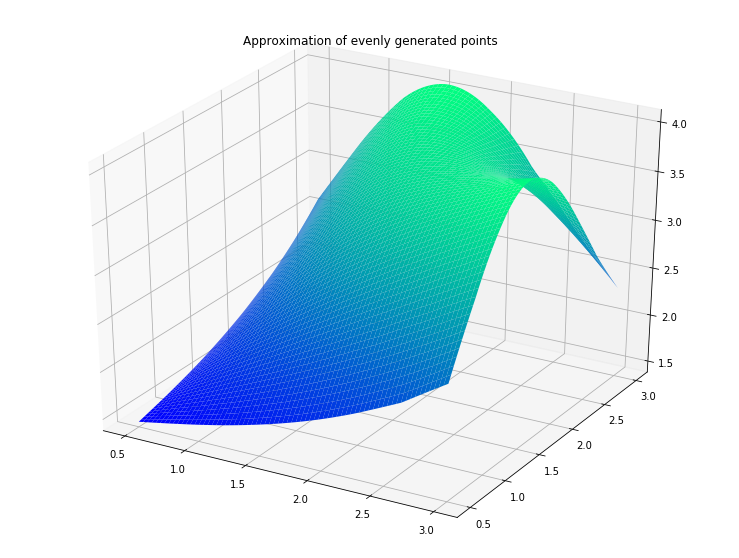

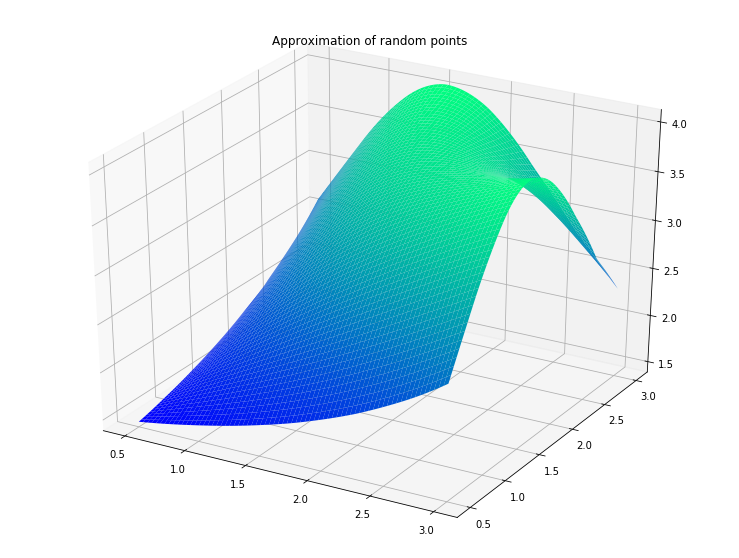

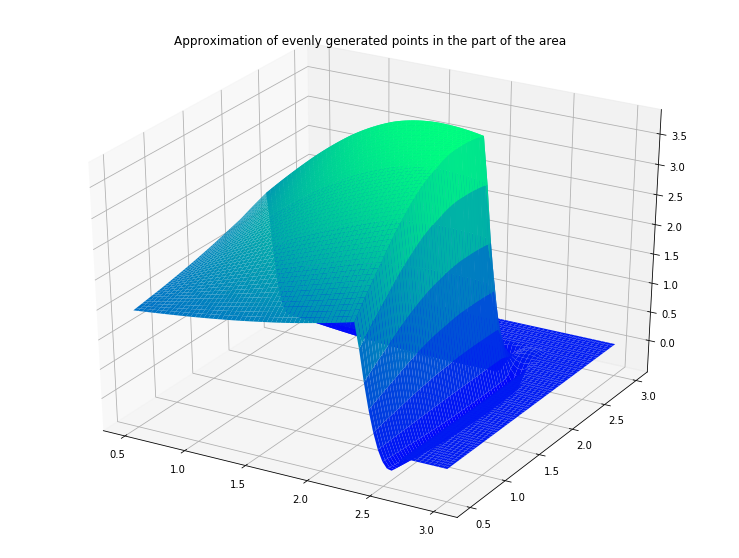

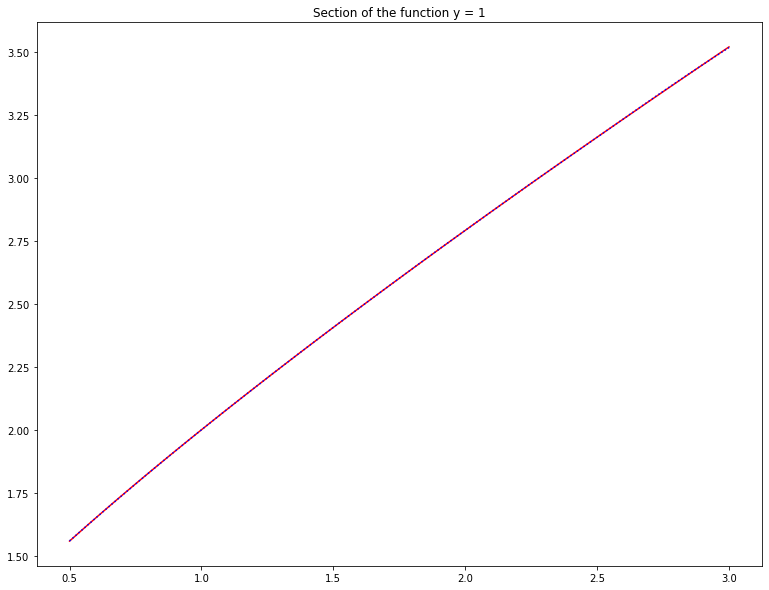

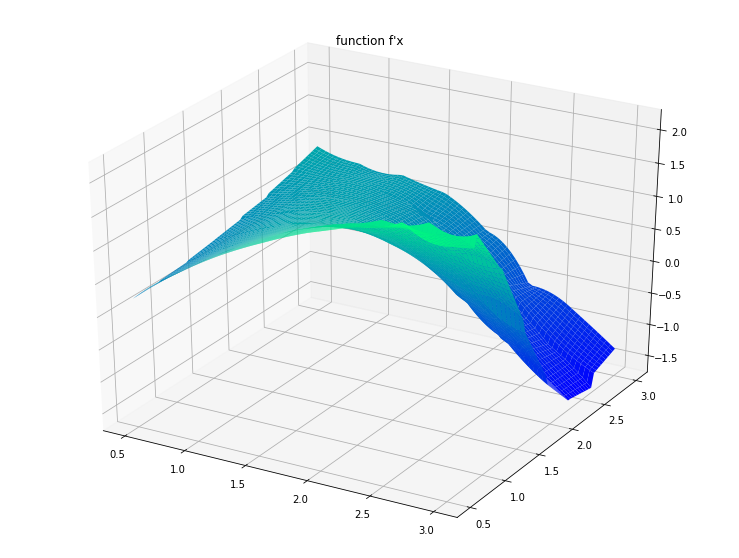

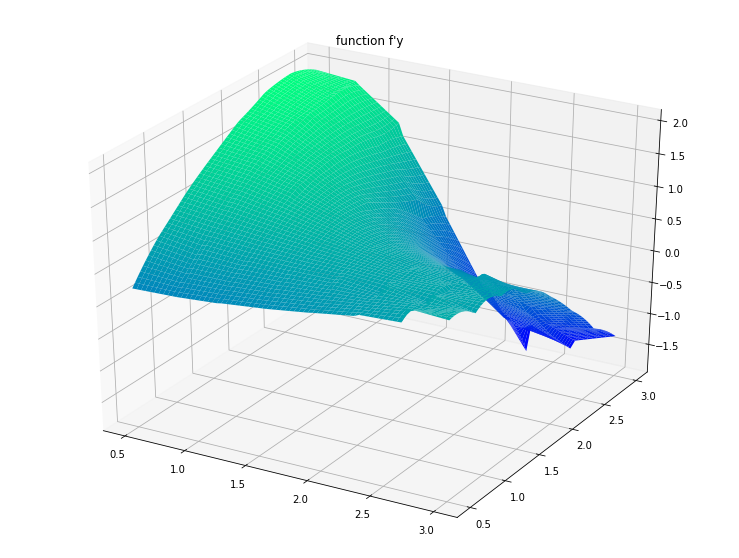

In [144]:
process(lambda x, y: x**(np.sin(y)) + y**(np.sin(x)), 
        lambda x, y: np.sin(y) * (x ** np.sin(y) - 1) + np.log(y) * y ** np.sin(x), 
        lambda x, y: np.sin(x) * (y ** np.sin(x) - 1) + np.log(x) * x ** np.sin(y),
        left_down_point=(0.5, 0.5), right_up_point=(3, 3),
        x_el_num=7, y_el_num=7, x_pol_deg=2, y_pol_deg=2,
        area=0.7, gen_points_num=500, gen_points_per_el=None,
        section_params=(1, 1), h=0.0001, solve_function=lu)